# Training a RL agent with Stable Baselines3 using a GEM environment

This notebook serves as an educational introduction to the usage of Stable Baselines3 using a gym-electric-motor (GEM) environment. The goal of this notebook is to give an understanding of what Stable Baselines3 is and how to use it to train and evaluate a reinforcement learning agent that can solve a current control problem of the GEM toolbox.

## 1. What you need

Before you can start you need to make sure that you have both gym-electric-motor and Stable-Baselines3 installed. You can install both easily using pip:

- ```pip install gym-electric-motor```
- ```pip install stable-baselines3```

Alternatively, you can install them and their latest developer version directly from GitHub:

- https://github.com/upb-lea/gym-electric-motor
- https://github.com/DLR-RM/stable-baselines3

After you have done that you should be able to execute the following cells without any problems.

## 2. Setting up a GEM evironment

The basic idea behind reinforcement learning is to create a so-called agent, that should learn by itself to solve a specified task in a given environment. This environment gives the agent feedback on its actions an reinforces the targeted behavior.
In this notebook, the task is to train a controller for the current control of a *Permanent Magnet Synchronous Motor* (*PMSM*).
 
In the following, the used GEM-envrionment is briefly presented, but this notebook does not focus directly on the detailed usage of GEM. If you are new to the used environment and interested in finding out what it does and how to use it, you should take a look at the [educational notebook](GEM_tutorial.ipynb) which is dealing with GEM.

To save some space in this notebook, there is a function defined in an external python file called **getting_environment.py**. If you want to know how the environment's parameters are defined you can take a look at that file. By simply calling the **get_env()** function from the external file, you can set up an environment for a *PMSM* with discrete inputs.

The basic idea of the control-setup from the GEM-environment is displayed in the following figure. 

![Motor Setup](img/SCML_Setting.svg)

The agent controls the converter who converts the supply currents to the currents flowing into the motor - for the *PMSM*: $i_{sq}$ and $i_{sd}$

In the continuous case, the agent's action is controlling the converter's output voltage directly through means of duty cycling. In the discrete case, the agent's action decides which converter switches are open and which are closed. Therefore, only a discrete amount of options are available. This environment uses the *Discrete B6 Bridge Converter* which has six switches with eight different switching states. Thus, the agent has eight discrete actions.

![Motor Setup](img/B6.svg)

The motor is described through the schematic:

![Motor Setup](img/ESBdq1.svg)

Which leads to the electrical ODEs:

<h3 align="center">

$\frac{\mathrm{d}i_{sq}}{\mathrm{d}t} = \frac{u_{sq}-pL_d\omega_{me}i_{sd}-R_si_{sq}}{L_q}$

$\frac{\mathrm{d}i_{sd}}{\mathrm{d}t} = \frac{u_{sd}-pL_q\omega_{me}i_{sq}-R_si_{sd}}{L_d}$

$\frac{\mathrm{d}\epsilon_{el}}{\mathrm{d}t} = p\omega_{me}$
</h3>
The target for the agent is now to learn to control the currents. For this, a reference generator generates a trajectory that the agent has to follow. Therefore, he has to learn to solve the ODEs and convert voltages accordingly. 

For a deeper understanding of the used models behind the environment the documentation can be found [here](https://upb-lea.github.io/gym-electric-motor/).

The following code is using the pre-written function get_env to import a pre-defined GEM environment. Additionally, a RewardLogger callback is added to visualize the training progress after training.

In [1]:
from gym_electric_motor.core import Callback
class RewardLogger(Callback):
    def __init__(self):
        self._step_rewards = []
        self._mean_episode_rewards = []

    def on_step_end(self):
        self._step_rewards.append(self._env._reward)
    
    def on_reset_begin(self):
        self._mean_episode_rewards.append(np.mean(self._step_rewards))
        self._step_rewards = []
        
    def on_close(self):
        np.save(Path.cwd() / "saved_agents" / "EpisodeRewards.npy", np.array(self._mean_episode_rewards))

/home/darius/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
from getting_environment import get_env
env = get_env(training=True, callbacks=[RewardLogger()])

## 3. What is Stable Baselines3?



Stable Baselines3 collects Reinforcement Learning algorithms implemented in Pytorch. You can use it when you want to train an agent of a specific RL algorithm if you don't want to implement the algorithm yourself.

Stable Baselines3 is still a very new library with its current release being 0.9. That is why its collection of algorithms is not very large yet and most algorithms lack more advanced variants. However, its authors planned to broaden the available algorithms in the future. For currently available algorithms see their documentation:

- https://stable-baselines3.readthedocs.io/en/master/guide/rl.html

To use an agent provided by Stable Baselines3 your environment has to have a gym interface:

- https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html

## 4. Training an agent

To train an agent in Stable Baselines3 you need two things: The agent's algorithm and a function approximator representing the control policy. Mostly supported are Multilayer perceptron (MLP) and Convolutional Neural Network (CNN) function estimators. Check the algorithm in the documentation to see what estimator the algorithm you want to use supports. The authors current plan is to implement recurrent function estimators in the future, too.

### 4.1 Imports

The environment in this control problem has got a discrete action space. Therefore, the Deep-Q-Network (DQN) is a suitable agent:

- https://arxiv.org/abs/1312.5602

For the implementation of the DQN you can check Stable Baslines3's docs and see, that currently the MLP and the CNN are supported:

- https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html

In this tutorial a MLP is used. For this you have to import the DQN and the MlpPolicy. You can also see in the docs which gym spaces for the observation and the actions are supported. You might have to take that into account for your environment.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.dqn import MlpPolicy
from pathlib import Path

### 4.2 Setting the parameters

For the DQN algorithm you have to define a set of values. The policy_kwargs dictionary is a parameter which is directly given to the MlpPolicy. The net_arch key defines the network architecture of the MLP.

In [4]:
buffer_size = 200000 #number of old obsersation steps saved
learning_starts = 10000 # memory warmup
train_freq = 1 # prediction network gets an update each train_freq's step
batch_size = 25 # mini batch size drawn at each update step
policy_kwargs = {
        'net_arch': [64,64] # hidden layer size of MLP
        }
exploration_fraction = 0.1 # Fraction of training steps the epsilon decays 
target_update_interval = 1000 # Target network gets updated each target_update_interval's step
gamma = 0.99
verbose = 1 # verbosity of stable basline's prints

Additionally, you have to define how long your agent will train. You can just set a concrete number of steps or use knowledge of the environment's temporal resolution to define an in-simulation training time. In this example the agent is trained for five seconds which translates in this environment's case to 500000 steps.

In [5]:
tau = 1e-5
simulation_time = 5 # seconds
nb_steps = int(simulation_time // tau)

### 4.3 Starting the training

Once you've setup the environment and defined your parameters starting the training is nothing more than a one-liner. For each algorithm all you have to do is call its .learn() function. However, you should note that the execution of the training can take a long time. Currently, Stable Baselines3 does not provide any means of saving the training reward for later visualization. Therefore, a RewardLogger callback is used for this environment (see code a few cells above).

In [6]:
model = DQN(MlpPolicy, env, buffer_size=buffer_size, learning_starts=learning_starts ,train_freq=train_freq, 
            batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs, 
            exploration_fraction=exploration_fraction, target_update_interval=target_update_interval,
            verbose=verbose)
model.learn(total_timesteps=nb_steps)
env.close()

Using cpu device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


----------------------------------
| rollout/            |          |
|    exploration rate | 0.968    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2581     |
|    time_elapsed     | 0        |
|    total timesteps  | 1662     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.953    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2559     |
|    time_elapsed     | 0        |
|    total timesteps  | 2481     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.918    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 2560     |
|    time_elapsed     | 1        |
|    total timesteps  | 4314     |
----------------------------------
----------------------------------
| rollout/          

----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 88       |
|    fps              | 289      |
|    time_elapsed     | 1563     |
|    total timesteps  | 452433   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 442432   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration rate | 0.05     |
| time/               |          |
|    episodes         | 92       |
|    fps              | 286      |
|    time_elapsed     | 1720     |
|    total timesteps  | 492433   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    n_updates        | 482432   |
----------------------------------


### 4.4 Saving the model

When the training has finished you can save the model your DQN has learned to reuse it later, e.g. for evaluation or if you want to continue your training. For this, each Stable Baselines3 algorithm has a .save() function where you only have to specify your path.

In [7]:
model.save(Path.cwd() / "saved_agents" / "TutorialAgent")

## 5. Evaluating an agent

After you have trained your agent you would like to see how well it does on your control problem. For this you can look at a visual representation of your currents in a test trajectory or see how well your agent does in a test scenario.

### 5.1 Loading a model

First, before you start your evaluation you have to load a trained agent or take the trained agent from above which is still saved in the variable model. To load a trained agent you simply have to call the .load() function of your algorithm with the respective path.

In [8]:
model = DQN.load(Path.cwd() / "saved_agents" / "TutorialAgent")  #your agent

### 5.2 Taking a look at the mean reward per episode during training

The RewardLogger callback saved the mean reward per episode during training. There you can observe, how the training reward did grow over time and if any problems occured during training.

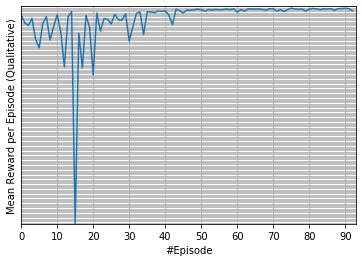

In [9]:
rewards = np.load(Path.cwd() / "saved_agents" / "EpisodeRewards.npy")[1:] # your training rewards
plt.grid(True)
plt.xlim(0,len(rewards))
plt.ylim(min(rewards), 0)
plt.yticks(np.arange(min(rewards), 1, 1.0))
plt.tick_params(axis = 'y', left = False, labelleft = False)
plt.xticks(np.arange(0, len(rewards), 10))
plt.xlabel('#Episode')
plt.ylabel('Mean Reward per Episode (Qualitative)')
plt.plot(rewards)
plt.show()

### 5.3 Taking a look at a test trajectory

You can to take a look at a test trajectory to see how well your trained agent is able to control the currents to follow the test trajectory. For the agent to decide for an action given an observation you can just call its .predict() function. The key deterministic is important so that the agent is not using a stochastic policy like epsilon greedy but is instead chosing an action greedily. The env.render() will then visualize the agent's and reference generator's trajectories as well as the reward.

/home/darius/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<IPython.core.display.Javascript object>


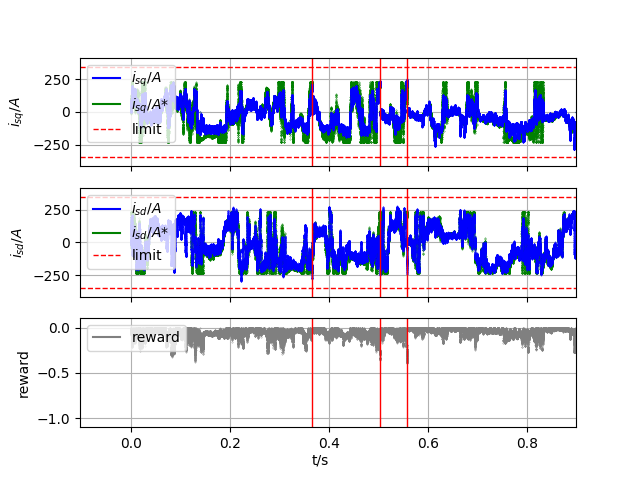

In [10]:
%matplotlib notebook
env = get_env(time_limit = False, training=False)
visualization_steps = int(9e4) # currently this crashes for larger values
obs = env.reset()
for i in range(visualization_steps):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action)
    env.render()
    if done:
        obs = env.reset()

### 5.4 Calculating further evaluation parameters

With the knowledge you acquired in the previous sections you are now able to train and evaluate any in Stable Baselines3 available reinforcement learning algorithm. The code below should give you an example how to use the trained agent to calculate a mean reward and mean episode length over a specific amount of steps. For further questions you can always have a look at the documentation of gym-electric-motor and Stable Baselines3 or raise an issue in their respective GitHub repositories.

In [11]:
test_steps = int(1e5)
cum_rew = 0
episode_step = 0
episode_lengths = []
for i in range(test_steps):
    print(f"{i+1}", end = '\r')
    episode_step += 1
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env.step(action)
    cum_rew += reward
    if done:
        episode_lengths.append(episode_step)
        episode_step = 0
        obs = env.reset()
print(f"The reward per step with {test_steps} steps was: {cum_rew/test_steps:.4f} ")
print(f"The average Episode length was: {round(np.mean(episode_lengths))} ")


The reward per step with 100000 steps was: -0.0444 
The average Episode length was: 14141.0 
